In [2]:
import csv
import numpy as np
from PIL import Image
import cv2
from matplotlib import image as mpimg
from matplotlib import pyplot as plt

In [15]:
csv_file = 'data/driving_log.csv'
img_paths = []
steering_angles = []
car_images = []
measurements = []

with open(csv_file, 'r') as f:
    reader = csv.reader(f)

    for i, row in enumerate(reader):
        if i == 0: continue

        steering_center = float(row[3])

        # create adjusted steering measurements for the side camera images
        correction = 0.2 # this is a parameter to tune
        steering_left = steering_center + correction
        steering_right = steering_center - correction

        # read in images from center, left and right cameras
        path = 'data/' # fill in the path to your training IMG directory
        img_center_path = path + row[0].strip()
        img_left_path = path + row[1].strip()
        img_right_path = path + row[2].strip()

        # add images and angles to data set
        img_paths.extend([img_center_path, img_left_path, img_right_path])
        steering_angles.extend([steering_center, steering_left, steering_right])
        
        # Just for testing
        # open images
        img_center = np.asarray(Image.open(img_center_path))
        img_left = np.asarray(Image.open(img_left_path))
        img_right = np.asarray(Image.open(img_right_path))
        # stack images
        car_images.extend([img_center, img_left, img_right])
        
        measurements.append(steering_center)

In [16]:
len(car_images)

24108

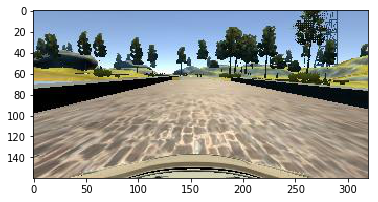

In [17]:
plt.imshow(np.asarray(Image.open(img_paths[0])))

In [18]:
X_train = np.array(car_images)
y_train = np.array(steering_angles)

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Cropping2D
from keras.layers.convolutional import Convolution2D

In [20]:
ch, row, col = 3, 160, 320  # camera format

model = Sequential()

# comma.ai architecture
model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(row, col, ch)))
model.add(Lambda(lambda x: x/127.5 - 1.))
model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(Flatten())
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(512))
model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(1))

# # The most basic NN possible
# model.add(Flatten(input_shape=(row, col, ch)))
# model.add(Dense(1))

# Basic with cropping and normalization
# model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(row, col, ch)))
# model.add(Lambda(lambda x: x/127.5 - 1.))
# model.add(Flatten())
# model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=1)
model.save('model.h5')

/Users/alex/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (8, 8), strides=(4, 4), padding="same")`
  
/Users/alex/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), strides=(2, 2), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/Users/alex/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), strides=(2, 2), padding="same")`
  if sys.path[0] == '':


Train on 19286 samples, validate on 4822 samples
Epoch 1/1
19286/19286 [==============================] - 665s 34ms/step - loss: 0.0704 - val_loss: 0.0255
